### Implementing XGBoost in Python


#### Steps and Notes for XGBoost
+ **Step 1**: Start with initial prediction. The default is 0.5 for classification and regression.
+ **Step 2**: Build a tree just like we do for XGBoost for regression. The root node starts with all the residuals in it.
+ **Step 3**: Calculate the similarity score of the leaf node. The similarity score is (sum of residuals)^2 / Sum[(Prev Prob.i * (1- Prev Prob.i)] + regularization term)
+ **Step 4**: Cluster similar residuals by splitting the tree. For each potential split, send the residuals down the tree into the potential left and right leaf nodes. Then, calculate the similarity score for the left and right leaves by plugging in the given leaf to the formula. Higher similarity means similar residuals.
+ **Step 5**: Calculate the gain just like we do for regression XGBoost. Gain = Left similarity + Right similarity - Root similarity. The highest gain is the best split. Keep building the tree as long as cover is not less than the predetermined threshold. (min_child_weight). The formula for cover is Sum[Prev Prob.i * (1 - Prev Prob.i)]
+ **Step 6**: Prune if needed. If Gain-Gamma is positive do not prune.
+ **Step 7**: Determine the output of the leaves. Output = Sum(residuals in the leaf) / Sum[Prev Prob.i * (1 - Prev Prob.i)] + regularization term.
+ Step 8**: Convert initial probability to log odds. Then, add this log odds to the output of the current tree * learning rate. The default learning rate is 0.3.
+ **Step 9**: Convert back to probability using e^log odds / (1 + e^log odds).
+ XGBoost cannot handle object datatypes. Convert to boolean or OneHotEncode them.
+ When using dataviz to draw the tree we cannot have whitespaces so convert them to underscores.
+ scale_pos_weight adds a penalty to incorrectly classified minority class predictions. XGBOOST recommends using sum(negative class) / sum(positive class). If there is a minority class then we will end up with a smaller number of residuals from this class in a node. These residuals will cancel out with residuals from the other class and a smaller similarity score will be the result so that the split may not be chosen. By using scale_pos_weight we scale the minority class by a number so that the residuals do not cancel out and in turn result in higher similarity and gain so that a split can be chosen to find the characteristics of the minority class data points. 

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# configure pandas to see all columns
pd.set_option('display.max_columns', None)

In [3]:
# import data
df = pd.read_csv('../data/Telco-Customer-Churn.csv')

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Now we can get a look at our columns. For each column we will print the column name followed by the length of the unique values and the unique values themselves. This tells us what variables are boolean.

In [7]:
for col in df.columns:
    print(col, len(df[col].unique()), df[col].unique())

customerID 7043 ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender 2 ['Female' 'Male']
SeniorCitizen 2 [0 1]
Partner 2 ['Yes' 'No']
Dependents 2 ['No' 'Yes']
tenure 73 [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService 2 ['No' 'Yes']
MultipleLines 3 ['No phone service' 'No' 'Yes']
InternetService 3 ['DSL' 'Fiber optic' 'No']
OnlineSecurity 3 ['No' 'Yes' 'No internet service']
OnlineBackup 3 ['Yes' 'No' 'No internet service']
DeviceProtection 3 ['No' 'Yes' 'No internet service']
TechSupport 3 ['No' 'Yes' 'No internet service']
StreamingTV 3 ['No' 'Yes' 'No internet service']
StreamingMovies 3 ['No' 'Yes' 'No internet service']
Contract 3 ['Month-to-month' 'One year' 'Two year']
PaperlessBilling 2 ['Yes' 'No']
PaymentMethod 4 ['Electronic check' 'Mailed check' 'Ban

In [8]:
df.drop('customerID', axis=1, inplace=True)

In [9]:
# total charges should be numeric but has an empty string so we cant do it easily.
df.loc[df['TotalCharges'] == ' ']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [10]:
# replace the empty space with a 0
df['TotalCharges'] = df['TotalCharges'].replace(' ', 0)

In [11]:
# make sure these are the same 11 we had previously
df.loc[df['TotalCharges'] == 0]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,No


In [12]:
# now convert the column to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [13]:
# make sure there is no whitespaces in any columns so that we can draw the tree
df.replace(' ', '_', regex=True, inplace=True)

##### Split the Data

As we will see shortly, we are going to use **early stopping**. Early stopping is a way to stop training as soon as the validation error reaches a minimum. As we train a model, the prediction error will go down on both the training and validation sets however, after a while, the validation error will start to go back up which means we have started to overfit the data. The metric we will be using is **aucpr**. If the validation aucpr score does not improve for 10 rounds we will stop learning. This will also make the model train faster.

The breakdown is as follows:
+ Step One: Split the data so that we have 20 percent for X_test and y_test. The other 80% will be X_train_val and y_train val.
+ Step Two: Create the training and validation set by splitting X_train_val and y_train val. Keep 20 percent for validation set.

In [14]:
# replace the Churn target variable with 1 for Churn and 0 for no Churn
df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})

C:\Users\ryans\AppData\Local\Temp\ipykernel_11008\1736284044.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})


In [15]:
# create X and y splits
X = df.drop('Churn', axis = 1).copy()
y = df['Churn'].copy()

In [16]:
# encode the categorical data using pd.get_dummies()
X_encoded = pd.get_dummies(X)

In [17]:
X_encoded

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No_phone_service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber_optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No_internet_service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No_internet_service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No_internet_service,DeviceProtection_Yes,TechSupport_No,TechSupport_No_internet_service,TechSupport_Yes,StreamingTV_No,StreamingTV_No_internet_service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No_internet_service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,0,1,29.85,29.85,True,False,False,True,True,False,True,False,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False
1,0,34,56.95,1889.50,False,True,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,True
2,0,2,53.85,108.15,False,True,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,True
3,0,45,42.30,1840.75,False,True,True,False,True,False,True,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,True,False,False,False
4,0,2,70.70,151.65,True,False,True,False,True,False,False,True,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84.80,1990.50,False,True,False,True,False,True,False,True,False,False,True,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,True,False,False,True,False,False,False,True
7039,0,72,103.20,7362.90,True,False,False,True,False,True,False,True,False,False,True,False,True,False,True,False,False,False,False,True,False,False,True,True,False,False,False,False,True,False,False,True,False,True,False,False,True,False,True,False,False
7040,0,11,29.60,346.45,True,False,False,True,False,True,True,False,False,True,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False
7041,1,4,74.40,306.60,False,True,False,True,True,False,False,True,False,False,True,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,True


##### Check the Balance of the Data

Since the data is imbalanced we will use the scoring metric **aucpr**. This helps with imbalanced datasets because accuracy scores can be misleading since the minority class is more rare. It is the area under the precision recall curve. The closer this value is to 1 the better. 

Precision:
+ Ratio of correctly predicted positive class (churns) to the total predicted positive class (churns)

Recall/Sensitivity:
+ Ratio of correctly predicted positive observations (churns) to all actual positive (churns)

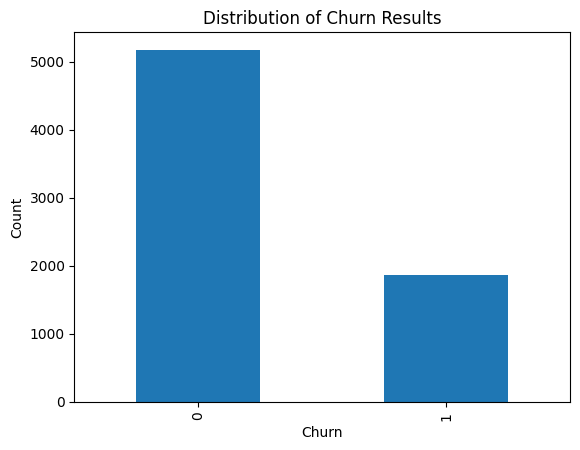

In [18]:
import matplotlib.pyplot as plt

# create counts for each
churn_counts = df['Churn'].value_counts()

# create plot
fig, ax = plt.subplots()
churn_counts.plot(kind='bar', ax=ax)
ax.set_xlabel('Churn')
ax.set_ylabel('Count')
ax.set_title('Distribution of Churn Results')
plt.show()


In [19]:
# how imbalanced is it
counts = df['Churn'].value_counts(normalize=True)
counts

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

In [20]:
# stratify split
X_train_val, X_test, y_train_val, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=42)


In [21]:
# check distribution
y_train_val.value_counts(normalize=True)

Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64

In [22]:
# verify stratification
y_test.value_counts(normalize=True)

Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64

In [23]:
# further split X_train_val and y_train_val to make validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)

In [24]:
# verify stratification
y_train.value_counts(normalize=True)

Churn
0    0.734635
1    0.265365
Name: proportion, dtype: float64

In [25]:
# verify stratification
y_val.value_counts(normalize=True)

Churn
0    0.734694
1    0.265306
Name: proportion, dtype: float64

In [26]:
# build the first model 
clf_xgb = XGBClassifier(objective='binary:logistic', eval_metric = 'aucpr', early_stopping_rounds = 10, seed=42) 
clf_xgb.fit(X_train,
            y_train,
            verbose = True,
            eval_set = [(X_val, y_val)])

[0]	validation_0-aucpr:0.61917
[1]	validation_0-aucpr:0.63717
[2]	validation_0-aucpr:0.63397
[3]	validation_0-aucpr:0.63668
[4]	validation_0-aucpr:0.63957
[5]	validation_0-aucpr:0.63184
[6]	validation_0-aucpr:0.64079
[7]	validation_0-aucpr:0.64561
[8]	validation_0-aucpr:0.64636
[9]	validation_0-aucpr:0.64478
[10]	validation_0-aucpr:0.64321
[11]	validation_0-aucpr:0.64515
[12]	validation_0-aucpr:0.64556
[13]	validation_0-aucpr:0.64463
[14]	validation_0-aucpr:0.64444
[15]	validation_0-aucpr:0.64520
[16]	validation_0-aucpr:0.64382
[17]	validation_0-aucpr:0.64384
[18]	validation_0-aucpr:0.64097


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

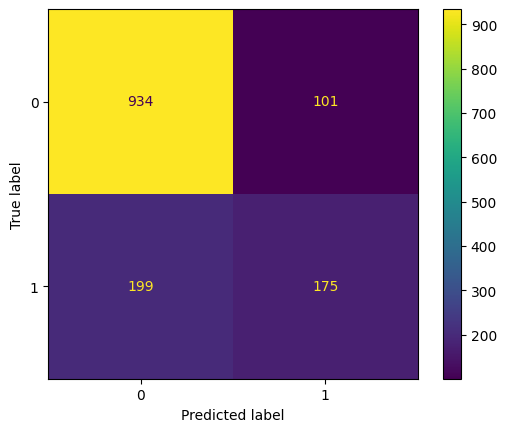

In [27]:
# create confusion matrix plot
ConfusionMatrixDisplay.from_estimator(clf_xgb, X_test, y_test)
plt.show()

#### Scoring Metrics

In [28]:
# valuation
true_negative = 934
false_positive = 101
false_negative = 199
true_positive = 175


Accuracy is the proportion of correctly classified instances. This number may be misleading for highly imbalanced datasets.
$$Accuracy = \frac{TN + TP}{TN + FP + FN + TP}$$


In [29]:
# accuracy score
accuracy_score = (true_negative + true_positive) / (true_negative + false_positive + false_negative + true_positive)
print(f'The model has an accuracy score of: {accuracy_score:.3f}')

The model has an accuracy score of: 0.787


Precision is the proportion of positive predictions that were correct. This is asking, "out of our positive predictions, how well did we do?" Or, "When we say positive, are we doing well." This calculation tries to reduce the false positives. If there are no false positives in our predictions then we are very good at making positive predictions and our precision will be 1. 
$$Precision = \frac{TP}{TP + FP}$$

Our model successfully predicted 175 of the true churners (True Positives), but incorrectly predicted 101 to churn as well (False Positives). This means that out of 276 predicted churners (175 True Positives + 101 False Positives), 175 predictions were correct.

In [30]:
# precision
precision_score = true_positive / (true_positive + false_positive)
print(f'The model has a precision score of: {precision_score:.3f}.')

The model has a precision score of: 0.634.


Recall is the proportion of actual positive cases that were correctly predicted. It is similar to precision but instead of grading our positive predictions we are grading our performance on the actual positive cases. This equation tries to minimize the false negatives. If this were a cancer diagnosis we would car more about recall rather than precision because a false negative is more costly than a false positive. 
$$Recall = \frac{TP}{TP + FN}$$

The model correctly classified 175 true churners but incorrecly classified 199 additional churners as non-churners. This means, out of the 374 actual churners we only predicted 175 correctly.

In [31]:
recall = true_positive / (true_positive + false_negative)
print(f'The model has a recall score of: {recall:.3f}')

The model has a recall score of: 0.468


##### Precision vs. Recall 

For churn data, high precision means that when we predict churn they are very likely to churn. This can give us insights on who we should reach out to and offer more services like discounts. A high recall in this example would mean we are good at identifying customers who churn. For example, if losing a customer is very costly, we would not care as much about false positives because we cannot lose someone. It is the false negatives that we care about more because we would not reach out to someone likely to churn. In this case we would like to balance both which is where the F1-score comes in to play. The F-1 score balances the trade-off between precision and recall. If we were to have **high precision and low recall** our model would catch most of the churners (high precision) but miss some (low recall due to false negatives). If we were to have **high recall and low precision** we would catch almost all churners (high recall) but incorrectly classify many non-churners as churners (low percision due to false positives). 

$$
F1 \, \text{Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$


In [32]:
# manual implementation
f1_score = 2 * ((precision_score * recall) / (precision_score + recall))
print(f'{f1_score:.3f}')

0.538


In [33]:
from sklearn.metrics import f1_score

y_pred = clf_xgb.predict(X_test)
f1_sklearn = f1_score(y_test, y_pred)
print(f'{f1_sklearn:.3f}')

0.538


### Cross Validation

The results of our model are not very promising. We can use cross-validation with GridSearchCV to find the best hyperparameters in our model.

Things we will optimize:
+ max_depth - maximum depth of the trees
+ learning_rate - step size shrinkage used in boosting to prevent overfitting. Higher values can speed up training but lead to overfitting. Typical range is 0.01 - 0.3
+ gamma - encourages pruning. If gain - gamma < 0, do not allow the split. The gain tells us if a split results in a higher similarity score than its parent node so if this score is less than gamma, we do not need the split. We are already confident enough in the split we have in the parent node. 
+ lambda - ridge regression penalty


In [34]:
# set up param grid
param_grid = {
    'max_depth': [4, 5],
    'learning_rate': [0.01, 0.2, 0.3], 
    'gamma' : [0, 0.25, 0.5],         
    'reg_lambda': [1, 10, 100],     
    'scale_pos_weight': [3, 5]   
}

To speed things up and help with overfitting, we are going to use a subset of rows and columns when performing our cross-validation search. 

In [35]:
# perform grid search
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', eval_metric = 'aucpr', seed=42,
                                 subsample = 0.9, colsample_bytree = 0.75), 
                                 param_grid=param_grid, 
                                 scoring='roc_auc',
                                 verbose=2,
                                 n_jobs=10,
                                 cv = 5
) 

grid_search.fit(X_train, y_train,
            eval_set = [(X_val, y_val)], 
            verbose = False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.75,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='aucpr', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=No...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=10,
             param_grid={'gamma': [0, 0.25, 0.5],
                         'learning_rate': [0.01, 0.2, 0.3], 'max_depth': [4, 5],
                         'reg_lambda': [1, 10, 100],
                         'scale_pos_weight': [3, 5]},
             scoring='roc_auc', verbose=2)

In [36]:
# view best params
best_params = grid_search.best_params_

In [37]:
print(best_params)

{'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'reg_lambda': 1, 'scale_pos_weight': 3}


In [38]:
model_2 = xgb.XGBClassifier(objective='binary:logistic',
                            gamma = 0.5,
                            learning_rate = 0.01,
                            max_depth = 5,
                            reg_lambda = 1,
                            scale_pos_weight = 3,
                            subsample = 0.9,
                            colsample_bytree = 0.75,
                            early_stopping_rounds = 10,
                            eval_metric = 'aucpr',
                            seed = 42)

model_2.fit(X_train, y_train,
            eval_set = [(X_val, y_val)], 
            verbose = False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

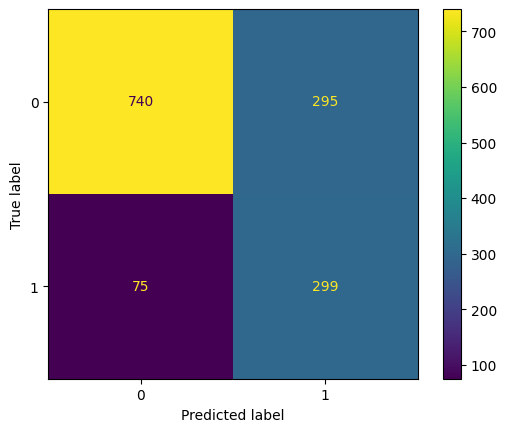

In [39]:
# create confusion matrix plot
ConfusionMatrixDisplay.from_estimator(model_2, X_test, y_test)
plt.show()

In [40]:
y_pred = model_2.predict(X_test)
f1_sklearn = f1_score(y_test, y_pred)
print(f'{f1_sklearn:.3f}')

0.618


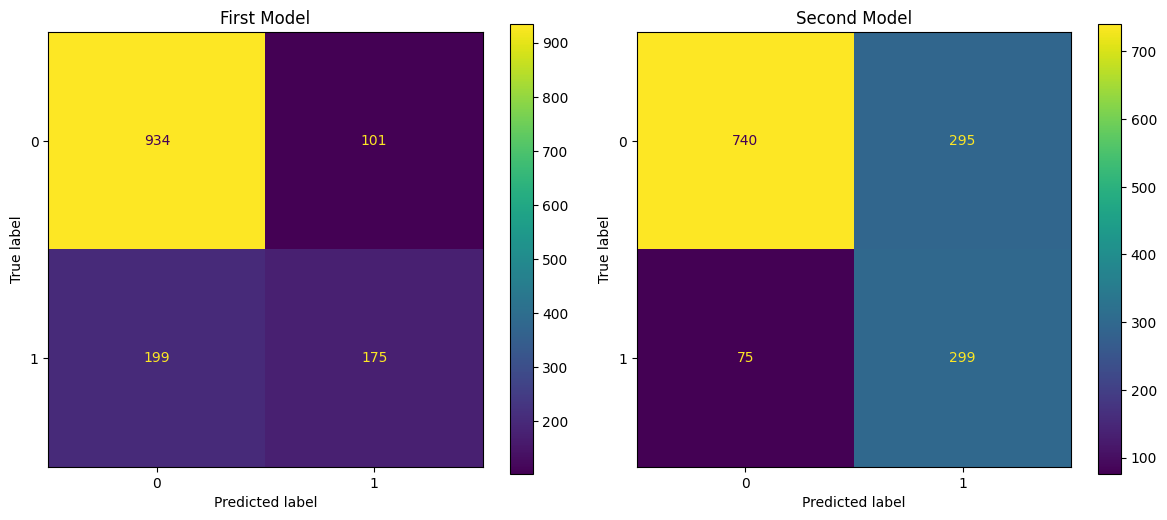

In [41]:
# plot both confusion matrices
# plot set up - 1 row, 2 cols
fig, axes = plt.subplots(1, 2, figsize=(12,5))
ConfusionMatrixDisplay.from_estimator(clf_xgb, X_test, y_test, ax=axes[0])
axes[0].title.set_text('First Model')

ConfusionMatrixDisplay.from_estimator(model_2, X_test, y_test, ax = axes[1])
axes[1].title.set_text('Second Model')

plt.tight_layout()
plt.show()

We see from the two confusion matrices above that the second model has a much higher **Recall**. This means we are better at capturing all the customers who will churn. In the first model we correctly predicted that 175 of the 374 people will churn and in the second model we correctly predicted 299 of the same 374 people. Although this is good, our **Precision** and **Accuracy** went down. For precision in the first model, 175 of the 276 people we predicted to churn actually did. However, our precision has gone down a lot. Our second model correctly predicted 299 actual churners, but predicted an additional 295 customers to also churn that did not. Our accuracy has also decreased from 78% to 74%. Depending on the task at hand, each model can be the better choice. If the cost of someone churning out weighted the cost of giving benefits to non-churners, then the second model would be better. If giving out free incentives and spending resources on the false positively predicted churners was more expensive or costly than losing a few churners, the first model would be better. 

In terms of a telco company that may have customers using landlines, I would say that the second model is better. This is a dying technology with the enhancements of cell phone towers and better service with more applications so they cannot afford to lose any customers. If they were to give out a free month or any additional service such as voicemail to a predicted churner that was not actually going to churn, it would not hurt as bad as losing someone who was going to churn but did not receive special care.

In [42]:
# metrics for second model
true_negative = 740
true_positive = 299
false_negative = 75
false_positive = 295

In [43]:
# accuracy score
accuracy_score = (true_negative + true_positive) / (true_negative + false_positive + false_negative + true_positive)
print(f'The second model has an accuracy score of: {accuracy_score:.3f}')

The second model has an accuracy score of: 0.737


In [44]:
# precision score
precision_score = true_positive / (true_positive + false_positive)
print(f'The second model has a precision score of: {precision_score:.3f}.')

The second model has a precision score of: 0.503.


In [45]:
# recall
recall = true_positive / (true_positive + false_negative)
print(f'The second model has a recall score of: {recall:.3f}')

The second model has a recall score of: 0.799


In [46]:
# manual implementation
f1_score = 2 * ((precision_score * recall) / (precision_score + recall))
print(f'{f1_score:.3f}')

0.618


#### Using Optuna

In [47]:
import optuna

# Define objective function 
def objective(trial): 
    # Define the hyperparameter search space 
    param = { 'objective': 'binary:logistic',
              'eval_metric': 'aucpr',
              'seed': 42,
              'subsample': 0.9,
              'colsample_bytree': 0.5,
              'max_depth': trial.suggest_int('max_depth', 3, 5), 
              'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2), 
              'gamma': trial.suggest_float('gamma', 0, 1), 
              'reg_lambda': trial.suggest_int('reg_lambda', 1, 100), 
              'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 5) } 
    
    # Train the model 
    model = xgb.XGBClassifier(**param) 
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    #  Make predictions and evaluate 
    preds = model_2.predict_proba(X_test)[:, 1] 
    roc_auc = roc_auc_score(y_test, preds) 
    return roc_auc

In [48]:
# Create and run the Optuna study 
study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=25)

[I 2025-01-17 10:37:51,796] A new study created in memory with name: no-name-1dab4352-66ae-4933-ae56-af724ae1d561
[I 2025-01-17 10:37:52,038] Trial 0 finished with value: 0.8332403317058049 and parameters: {'max_depth': 4, 'learning_rate': 0.01656507222966764, 'gamma': 0.7962069041981199, 'reg_lambda': 25, 'scale_pos_weight': 3}. Best is trial 0 with value: 0.8332403317058049.
[I 2025-01-17 10:37:52,271] Trial 1 finished with value: 0.8332403317058049 and parameters: {'max_depth': 3, 'learning_rate': 0.0714181289181093, 'gamma': 0.19019188702799739, 'reg_lambda': 93, 'scale_pos_weight': 2}. Best is trial 0 with value: 0.8332403317058049.
[I 2025-01-17 10:37:52,510] Trial 2 finished with value: 0.8332403317058049 and parameters: {'max_depth': 3, 'learning_rate': 0.13079182744772008, 'gamma': 0.49133353470843044, 'reg_lambda': 93, 'scale_pos_weight': 2}. Best is trial 0 with value: 0.8332403317058049.
[I 2025-01-17 10:37:52,825] Trial 3 finished with value: 0.8332403317058049 and paramet

In [49]:
# Display the best hyperparameters and score 
print("Best Hyperparameters:", study.best_params) 
print("Best ROC-AUC Score:", study.best_value)

Best Hyperparameters: {'max_depth': 4, 'learning_rate': 0.01656507222966764, 'gamma': 0.7962069041981199, 'reg_lambda': 25, 'scale_pos_weight': 3}
Best ROC-AUC Score: 0.8332403317058049


In [50]:
# Initialize the model with the best hyperparameters 
best_model = xgb.XGBClassifier( objective='binary:logistic', eval_metric='aucpr', seed=42, subsample=0.9, colsample_bytree=0.5, **best_params )
 # Train the model 
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

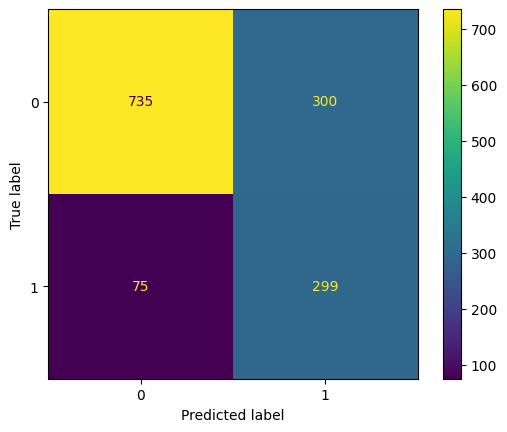

In [51]:
# this model is similar to grid search model but not quite as good.
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

##### Visualization

Let's build just one tree to get a sense of how it works. We can do this by setting **n_estimators** to 1. This restricts the classifier from building additional trees.

In [54]:
view_tree = xgb.XGBClassifier(objective='binary:logistic',
                            gamma = 0.5,
                            learning_rate = 0.01,
                            max_depth = 5,
                            reg_lambda = 1,
                            scale_pos_weight = 3,
                            subsample = 0.9,
                            colsample_bytree = 0.75,
                            eval_metric = 'aucpr',
                            n_estimators = 1,
                            seed = 42
)

# fit the model with one tree to see how it is created
view_tree.fit(X_train, y_train,)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

#### Get Booster

**.get_booster()** is a method that allows us to access the underlying Booster object of an XGBoost model. The Booster object contains detailed information about the trained model. It allows us to access metrics such as weight, cover, and gain. These are found using **.get_score(importance_type)** and can help us optimize the model and tell us about which features are most important. 

**Importance Types**:
+ *Weight* - This is the number of times a feature is used to make a split across all trees (how many times it ends up in a branch or root). The idea is that the higher the weight is, the more important the feature is.
+ *Gain* - This is the average gain/improvement in accuracy brought by a feature to the branches its used on. Remember that gain is used to make splits and the best gain wins. This gain has to be larger than the parent root so if a feature has gain it is making the model more accurate. This tells us features that have the most impact on the tree building process.
+ *Total Gain* - Similar to gain but instead of averaging them, it is the cumulative value.
+ *Cover* - Average cover of the feature used in the split. Higher cover values tell us that the model sees room for improvement by using this split so it is accurately learning and adjusting predictions based on this feature will significantly reduce loss. If the cover is low it means that the model may already be confident enough in prior splits using this variable so there is no need to split further. The cover is the sum of all Hessian values that go through this node. This means a high cover normally tells us that this split affects a large number of samples since these values are summed. (cover is used at the node level.) Since it is the sum of values it can be thought of as number of samples in a node. 

Since we are only building one tree, total_gain and total_cover = gain and cover.

In [66]:
# Get importances
booster = view_tree.get_booster()

# Function to print importances sorted in descending order
def print_sorted_importances(importance_type):
    importances = booster.get_score(importance_type=importance_type)
    # importances is a dictionary {feature:value} so get the items and sort by second element - value
    sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\n{importance_type} importances (sorted):")
    for feature, importance in sorted_importances:
        print(f"Feature: {feature}, Importance: {importance}")

# Print statements about importances for each type
for importance_type in ['weight', 'gain', 'cover', 'total_gain', 'total_cover']:
    print_sorted_importances(importance_type)



weight importances (sorted):
Feature: MonthlyCharges, Importance: 10.0
Feature: TotalCharges, Importance: 7.0
Feature: InternetService_DSL, Importance: 2.0
Feature: StreamingTV_No, Importance: 2.0
Feature: PaymentMethod_Electronic_check, Importance: 2.0

gain importances (sorted):
Feature: Contract_Month-to-month, Importance: 1498.780517578125
Feature: OnlineBackup_No, Importance: 71.7156982421875
Feature: MonthlyCharges, Importance: 38.86055374145508
Feature: TotalCharges, Importance: 37.24319839477539
Feature: Contract_One_year, Importance: 34.23455810546875

cover importances (sorted):
Feature: Contract_Month-to-month, Importance: 1564.0
Feature: OnlineBackup_No, Importance: 385.5
Feature: Contract_One_year, Importance: 375.75
Feature: InternetService_DSL, Importance: 331.375
Feature: TotalCharges, Importance: 221.5

total_gain importances (sorted):
Feature: Contract_Month-to-month, Importance: 1498.780517578125
Feature: MonthlyCharges, Importance: 388.60552978515625
Feature: Total

We can use these feature importances for feature selection. It is always best to balance simplicity and accuracy so we can reduce the number of features for potentially only a small decrease in accuracy.

In [101]:
# Get importances
booster = view_tree.get_booster()

# Function to print and return top N importances sorted in descending order
def get_top_n_importances(importance_type, n=10):
    importances = booster.get_score(importance_type=importance_type)
    sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)[:n]
    return sorted_importances

# Define a function to combine importances and select top 5 features
def get_combined_top_features(n_each=10, top_overall=5):
    combined_importances = {}
    
    # Get top N features for each importance type
    for importance_type in ['weight', 'gain', 'cover']:
        top_importances = get_top_n_importances(importance_type, n_each)
        for feature, importance in top_importances:
            if feature in combined_importances:
                combined_importances[feature] += importance
            else:
                combined_importances[feature] = importance
    
    # Sort combined importances and select top overall features
    sorted_combined_importances = sorted(combined_importances.items(), key=lambda x: x[1], reverse=True)
    top_features_overall = sorted_combined_importances[:top_overall]
    
    return top_features_overall

# Get top 5 overall features
top_features_overall = get_combined_top_features(n_each=10, top_overall=5)

# Display top 5 overall features
print("Top 5 overall features (combined from all importance types):")
for feature, importance in top_features_overall:
    print(f"Feature: {feature}, Combined Importance: {importance}")


Top 5 overall features (combined from all importance types):
Feature: Contract_Month-to-month, Combined Importance: 3063.780517578125
Feature: OnlineBackup_No, Combined Importance: 458.2156982421875
Feature: Contract_One_year, Combined Importance: 410.98455810546875
Feature: InternetService_DSL, Combined Importance: 361.56893157958984
Feature: MonthlyCharges, Combined Importance: 270.01054763793945


In [102]:
# train a model based on these features
X_train_new = X_train[['Contract_Month-to-month', 'MonthlyCharges', 'TotalCharges', 'InternetService_DSL', 'OnlineBackup_No']]
y_train_new = y_train.copy()


In [103]:
# new model with most important variables. Don't sample the columns each tree.
new_model = xgb.XGBClassifier(objective='binary:logistic',
                            gamma = 0.5,
                            learning_rate = 0.01,
                            max_depth = 5,
                            reg_lambda = 1,
                            scale_pos_weight = 3,
                            subsample = 0.9,
                            eval_metric = 'aucpr',
                            seed = 42
)

new_model.fit(X_train_new, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Using these new features we have captured a few more actual churners. We also used less features to do so and the more simple a model is the better.

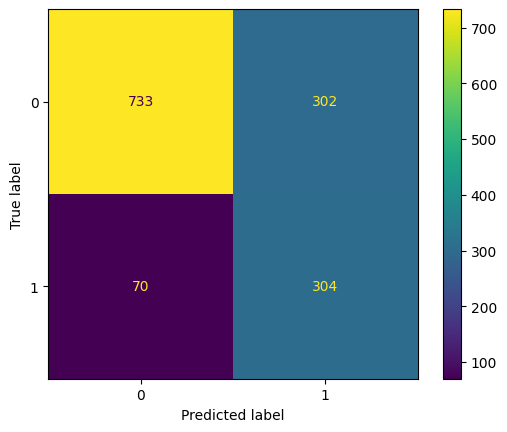

In [104]:
X_test_new = X_test[['Contract_Month-to-month', 'MonthlyCharges', 'TotalCharges', 'InternetService_DSL', 'OnlineBackup_No']]
ConfusionMatrixDisplay.from_estimator(new_model, X_test_new, y_test)
plt.show()

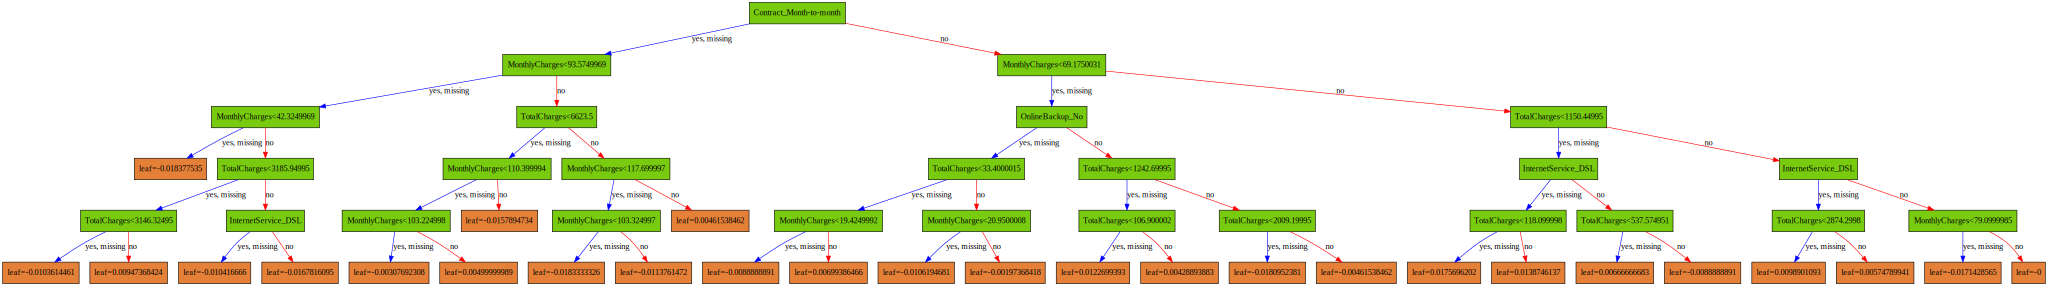

In [ ]:
# customize tree layout design
node_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}
# graph the tree
tree = xgb.to_graphviz(new_model, num_trees=0, size="6,6",
                condition_node_params=node_params, 
                leaf_node_params=leaf_params)
# view the tree
tree

In [100]:
# save image to png
with open('tree.dot', 'w') as f:
     f.write(tree.source) 
# Render the image using Graphviz 
import os 
os.system('dot -Tpng tree.dot -o tree.png')

0

### Interpreting the Tree

The root node is **Contract_Month-to-month**. This is a binary categorical feature which results in a yes or a no. If the person does have the contract month to month OR that piece of data is missing from the observation, they go to the left branch. Otherwise, they go to the right. For continuous variables like MonthlyCharges, a threshold will be decided based on similarity score and gain. The leaf node output values are small increases or decreases in the probability to Churn. 